In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# ETL libraries
from ETL import ETL

from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# New York Analysis

In [2]:
df = pd.read_csv('dataset/2012.csv')

In [3]:
filtered_df = df[['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'DISTANCE', 'AIR_TIME']]

print(filtered_df.head())


      FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
0  2012-01-01      -13.0      -13.0    BMI  ORD     116.0      37.0
1  2012-01-01       -5.0      -16.0    ORD  BMI     116.0      23.0
2  2012-01-01      -10.0      -20.0    SGF  ORD     438.0      75.0
3  2012-01-01       -6.0      -15.0    ORD  DBQ     147.0      31.0
4  2012-01-01       15.0        9.0    ORD  RIC     642.0      86.0


In [4]:
ny_airports = ['LAX']
filtered_df['FL_DATE'] = pd.to_datetime(filtered_df['FL_DATE'])
ny_flights_depatures = filtered_df[
    (filtered_df['ORIGIN'].isin(ny_airports)) & 
    (filtered_df['AIR_TIME'].notna())
]
ny_flights_arrivals = filtered_df[
    (filtered_df['DEST'].isin(ny_airports)) & 
    (filtered_df['AIR_TIME'].notna())
]

print(ny_flights_depatures.head())
print(ny_flights_arrivals.head())

C:\Users\dswal\AppData\Local\Temp\ipykernel_15480\2447999021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['FL_DATE'] = pd.to_datetime(filtered_df['FL_DATE'])


       FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
318 2012-01-01        1.0        0.0    LAX  SBA      89.0      21.0
322 2012-01-01       15.0       22.0    LAX  YUM     237.0      54.0
336 2012-01-01       -3.0        3.0    LAX  SAT    1210.0     154.0
340 2012-01-01      147.0      141.0    LAX  COS     833.0     117.0
341 2012-01-01       -2.0       -7.0    LAX  FAT     209.0      34.0
       FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
317 2012-01-01       14.0       10.0    BOI  LAX     674.0     108.0
337 2012-01-01       -8.0      -12.0    SMF  LAX     373.0      66.0
346 2012-01-01      -12.0       -3.0    SMF  LAX     373.0      62.0
349 2012-01-01       -8.0        7.0    PHX  LAX     370.0      58.0
361 2012-01-01       -7.0      -15.0    PSP  LAX     110.0      25.0


In [5]:
# identifichiamo la settimana

daily_departures = ny_flights_depatures.groupby('FL_DATE').size().reset_index(name='DEPARTURES')
daily_arrivals = ny_flights_arrivals.groupby('FL_DATE').size().reset_index(name='ARRIVALS')
daily_traffic = pd.merge(daily_departures, daily_arrivals, on='FL_DATE', how='outer').fillna(0)

daily_traffic['TOTAL_TRAFFIC'] = daily_traffic['DEPARTURES'] + daily_traffic['ARRIVALS']

print(daily_traffic.head())
print(ny_flights_depatures.head())
print(ny_flights_arrivals.head())



     FL_DATE  DEPARTURES  ARRIVALS  TOTAL_TRAFFIC
0 2012-01-01         547       540           1087
1 2012-01-02         641       631           1272
2 2012-01-03         580       578           1158
3 2012-01-04         571       567           1138
4 2012-01-05         608       612           1220
       FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
318 2012-01-01        1.0        0.0    LAX  SBA      89.0      21.0
322 2012-01-01       15.0       22.0    LAX  YUM     237.0      54.0
336 2012-01-01       -3.0        3.0    LAX  SAT    1210.0     154.0
340 2012-01-01      147.0      141.0    LAX  COS     833.0     117.0
341 2012-01-01       -2.0       -7.0    LAX  FAT     209.0      34.0
       FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
317 2012-01-01       14.0       10.0    BOI  LAX     674.0     108.0
337 2012-01-01       -8.0      -12.0    SMF  LAX     373.0      66.0
346 2012-01-01      -12.0       -3.0    SMF  LAX     373.0      62.0
349 2012-0

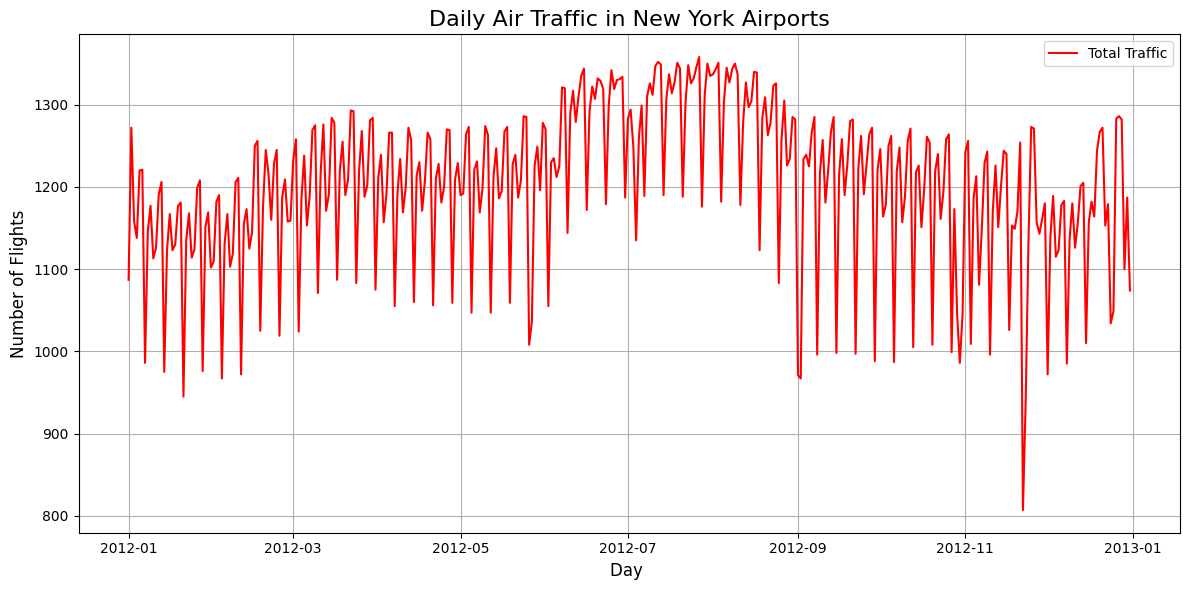

In [6]:
plt.figure(figsize=(12, 6))
#plt.plot(daily_traffic['FL_DATE'], daily_traffic['DEPARTURES'], marker='o', linestyle='-', color='b', label='Departures')
#plt.plot(daily_traffic['FL_DATE'], daily_traffic['ARRIVALS'], marker='o', linestyle='--', color='g', label='Arrivals')
plt.plot(daily_traffic['FL_DATE'], daily_traffic['TOTAL_TRAFFIC'], linestyle='-', color='r', label='Total Traffic')
plt.title('Daily Air Traffic in New York Airports', fontsize=16)
plt.xlabel('Day ', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Temporal Series

In [2]:
df = pd.read_csv('dataset/best_route_flights.csv')

In [3]:
df = ETL(df)

In [4]:
df = df[['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'DISTANCE', 'AIR_TIME']]

df.head()

,FL_DATE,DEP_DELAY,ARR_DELAY,ORIGIN,DEST,DISTANCE,AIR_TIME
0,2009-01-01,-2.0,-20.0,SFO,LAX,337.0,56.0
1,2009-01-01,-8.0,-28.0,SFO,LAX,337.0,54.0
2,2009-01-01,5.0,-8.0,SFO,LAX,337.0,55.0
3,2009-01-01,13.0,-7.0,SFO,LAX,337.0,53.0
4,2009-01-01,-6.0,-29.0,SFO,LAX,337.0,53.0


In [5]:
df['FL_DATE']= pd.to_datetime(df['FL_DATE'])
df['FL_DATE']=df['FL_DATE'].dt.normalize()
daily_analysis = df.groupby("FL_DATE").agg(
    AVG_DEP_DELAY=("DEP_DELAY","mean"),
    AVG_ARR_DELAY=("ARR_DELAY", "mean"),
    AVG_AIR_TIME=("AIR_TIME", "mean"),  # Tempo medio di volo
).fillna(0) 

daily_analysis

,AVG_DEP_DELAY,AVG_ARR_DELAY,AVG_AIR_TIME
FL_DATE,,,
2009-01-01,12.103448,0.896552,55.275862
2009-01-02,48.971429,43.400000,51.371429
2009-01-03,1.241379,-5.655172,54.862069
2009-01-04,8.181818,-5.333333,52.696970
2009-01-05,27.571429,16.371429,47.342857
...,...,...,...
2018-12-27,15.560976,15.585366,52.097561
2018-12-28,10.292683,10.243902,53.975610
2018-12-29,4.441176,-1.970588,55.205882


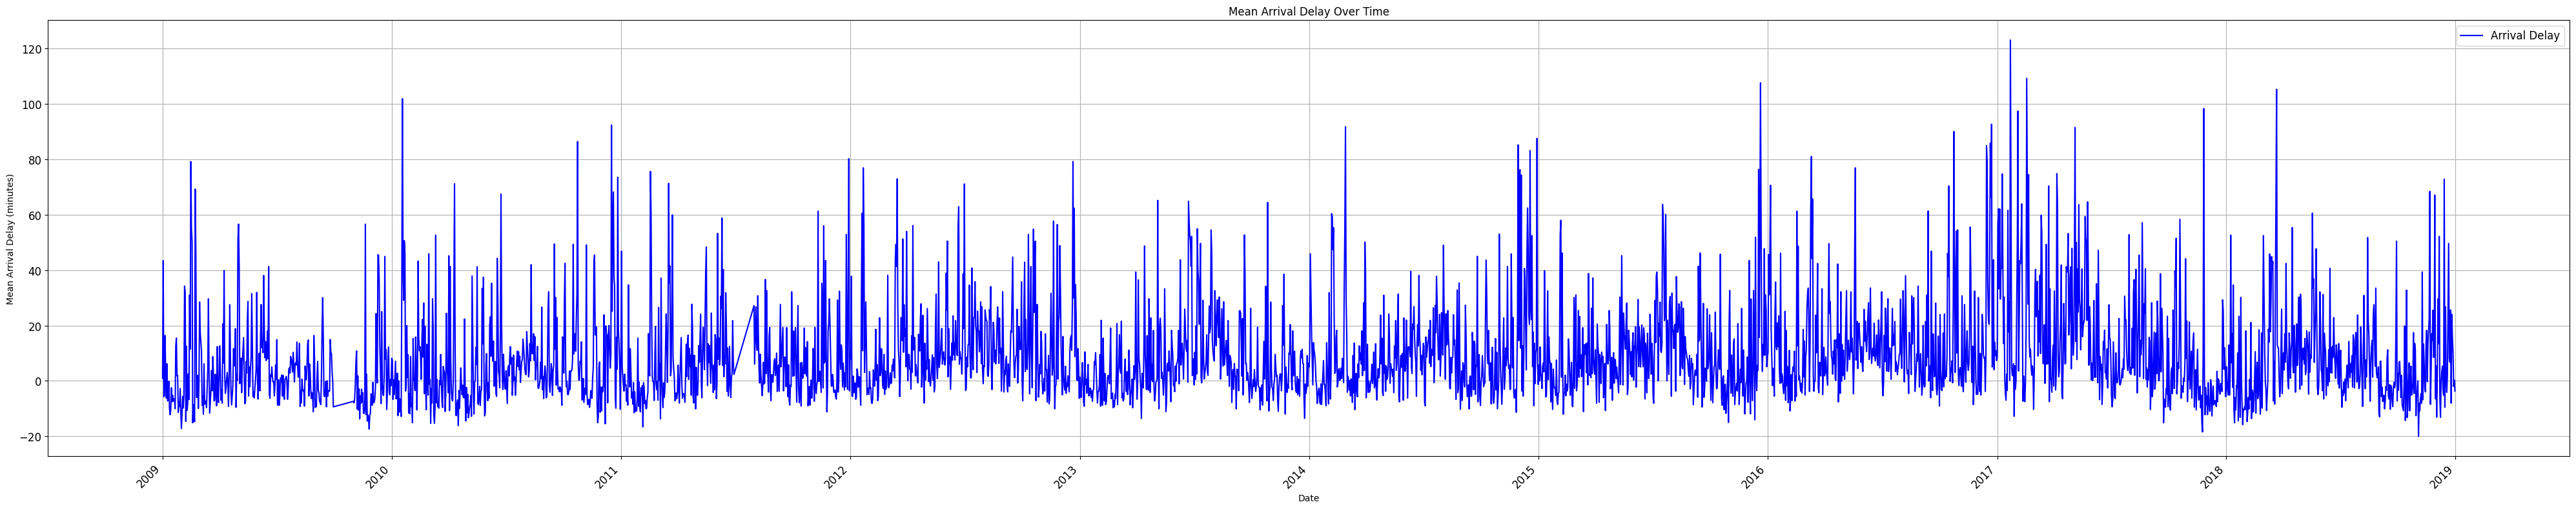

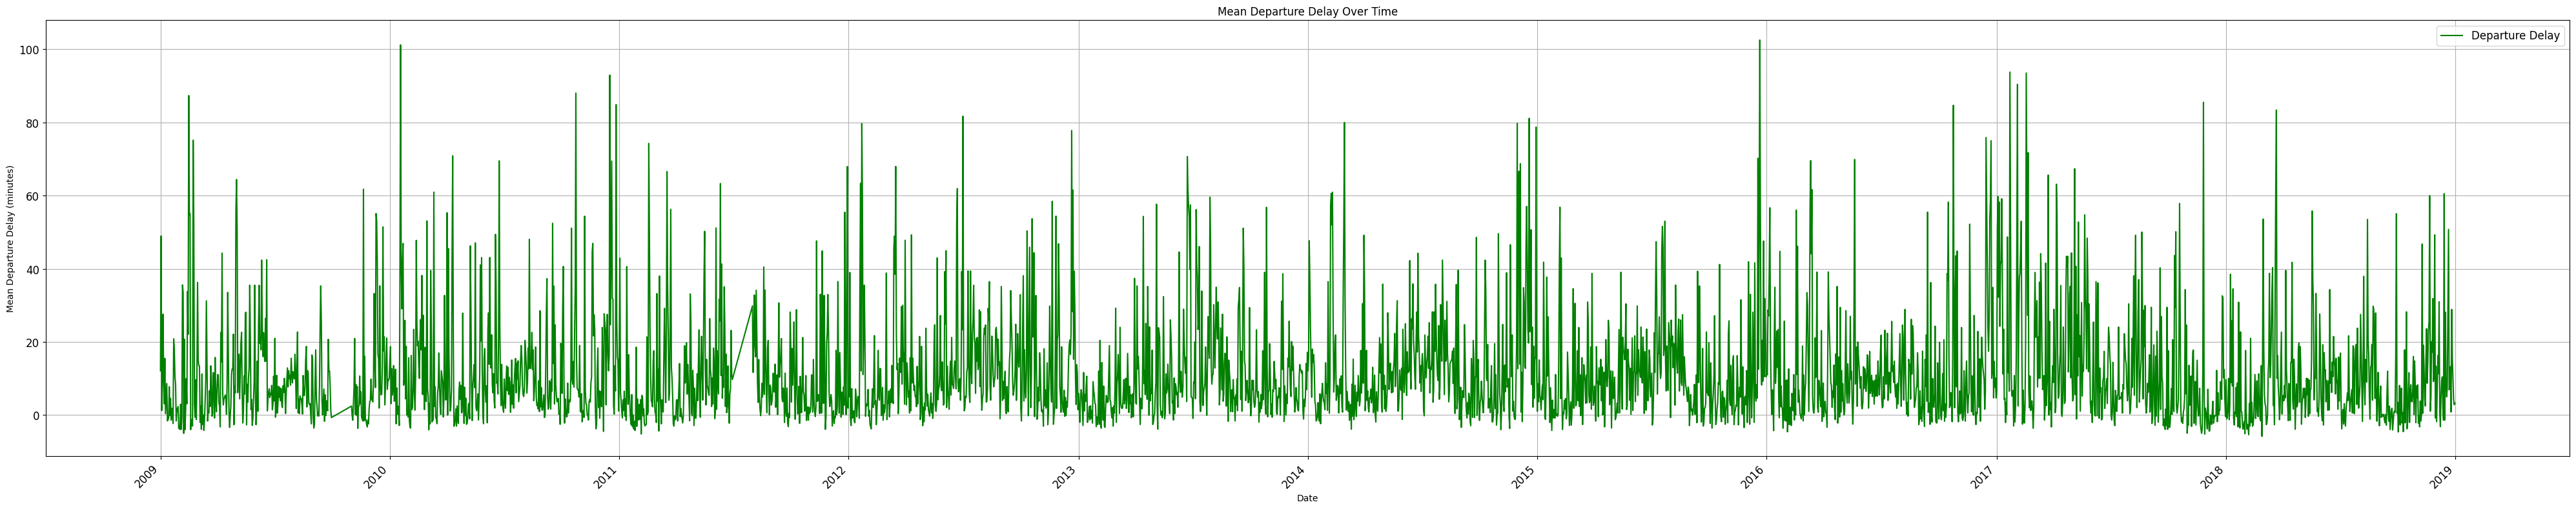

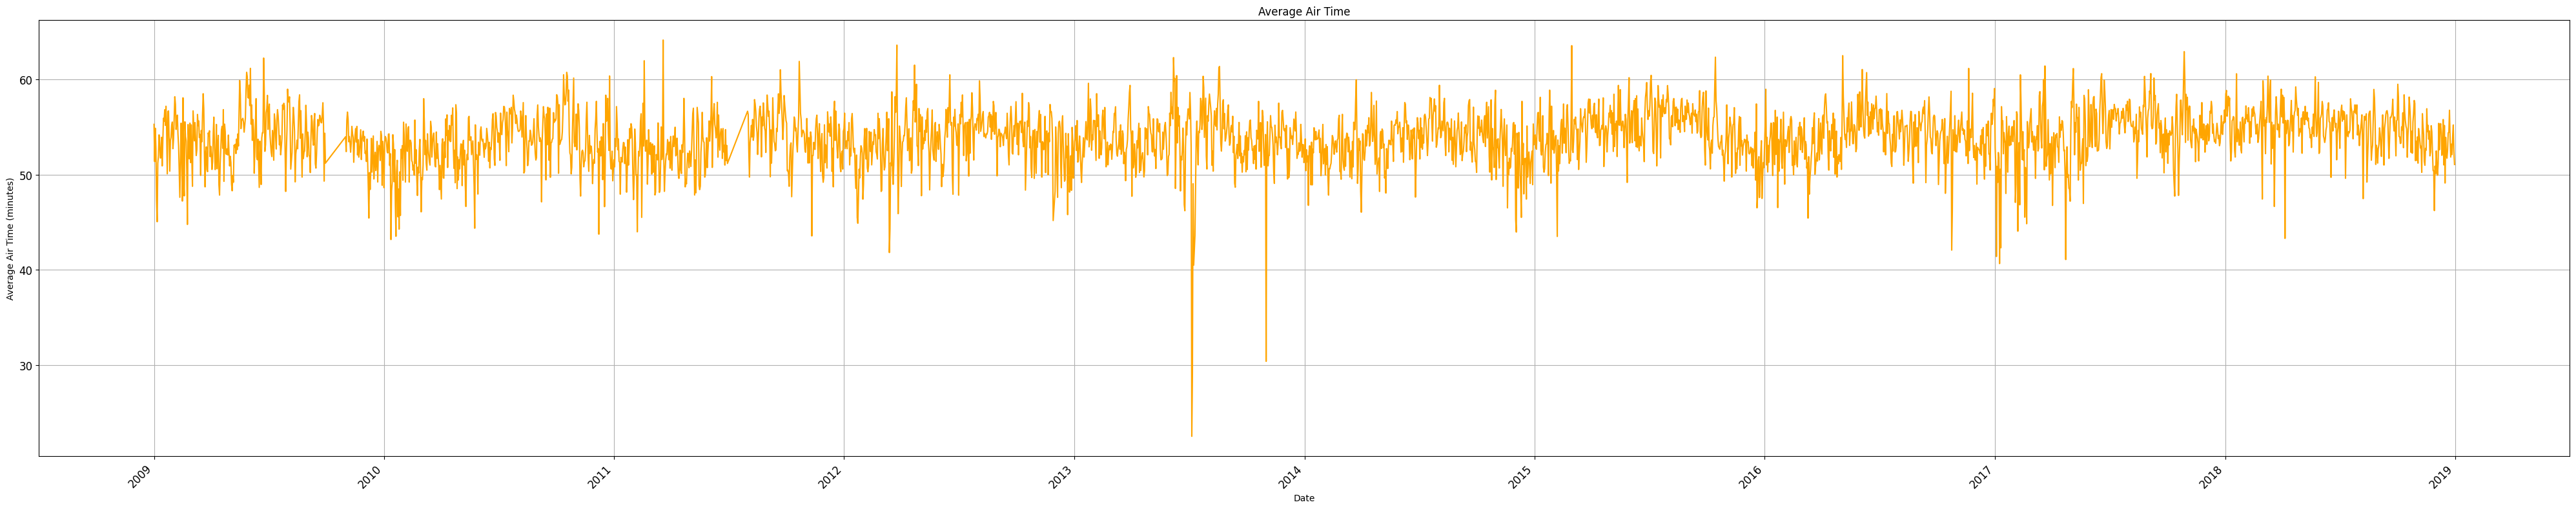

In [6]:
# Grafico del ritardo totale nel tempo (partenza e arrivo)
daily_analysis["AVG_ARR_DELAY"].plot(
    figsize=(40, 8), linestyle='-', color='b', 
    title="Mean Arrival Delay Over Time", grid=True, 
    xlabel="Date", ylabel="Mean Arrival Delay (minutes)", label="Arrival Delay"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Grafico del ritardo totale in partenza nel tempo
daily_analysis["AVG_DEP_DELAY"].plot(
    figsize=(40, 8), linestyle='-', color='g', 
    title="Mean Departure Delay Over Time", grid=True, 
    xlabel="Date", ylabel="Mean Departure Delay (minutes)", label="Departure Delay"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Grafico della media del tempo di volo
daily_analysis["AVG_AIR_TIME"].plot(
    figsize=(40, 8), color='orange', 
    title="Average Air Time", grid=True, 
    xlabel="Date", ylabel="Average Air Time (minutes)"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



## Arrival delay

<Axes: xlabel='FL_DATE'>

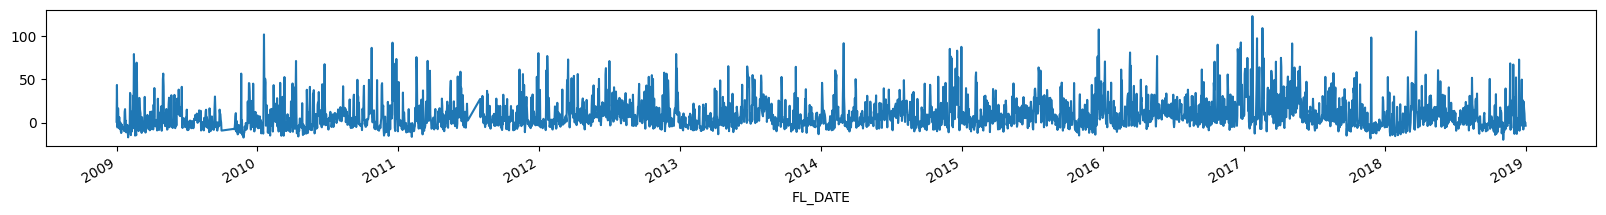

In [7]:
daily_analysis_arr = daily_analysis['AVG_ARR_DELAY']
daily_analysis_arr.plot(figsize=(20, 2))

### Stazionarietà

In [8]:
X = daily_analysis_arr.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.491564
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Stagionalità, trend e residui

In [9]:
# Trasforma la Series in un DataFrame con una sola colonna
daily_analysis_df = daily_analysis_arr.to_frame(name='AVG_ARR_DELAY')

# Applica il metodo asfreq e controlla i valori NaN
nan_values = daily_analysis_df.asfreq('D').isna()

# Ora puoi accedere alla colonna 'AVG_ARR_DELAY'
nan_indices = nan_values[nan_values['AVG_ARR_DELAY'] == True].index
print(nan_indices)


DatetimeIndex(['2009-10-01', '2009-10-02', '2009-10-03', '2009-10-04',
               '2009-10-05', '2009-10-06', '2009-10-07', '2009-10-08',
               '2009-10-09', '2009-10-10', '2009-10-11', '2009-10-12',
               '2009-10-13', '2009-10-14', '2009-10-15', '2009-10-16',
               '2009-10-17', '2009-10-18', '2009-10-19', '2009-10-20',
               '2009-10-21', '2009-10-22', '2009-10-23', '2009-10-24',
               '2009-10-25', '2009-10-26', '2009-10-27', '2009-10-28',
               '2009-10-29', '2009-10-30', '2009-10-31', '2011-07-01',
               '2011-07-02', '2011-07-03', '2011-07-04', '2011-07-05',
               '2011-07-06', '2011-07-07', '2011-07-08', '2011-07-09',
               '2011-07-10', '2011-07-11', '2011-07-12', '2011-07-13',
               '2011-07-14', '2011-07-15', '2011-07-16', '2011-07-17',
               '2011-07-18', '2011-07-19', '2011-07-20', '2011-07-21',
               '2011-07-22', '2011-07-23', '2011-07-24', '2011-07-25',
      

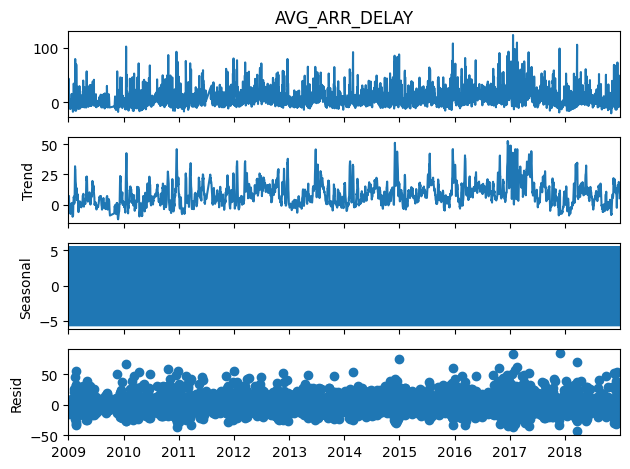

In [10]:
# Perform seasonal decomposition
dec2 = seasonal_decompose(daily_analysis_arr.asfreq('D').interpolate('linear'), model='additive')
dec2.plot()
plt.show()


### Autocorrelazione Parziale e Autocorrelazione

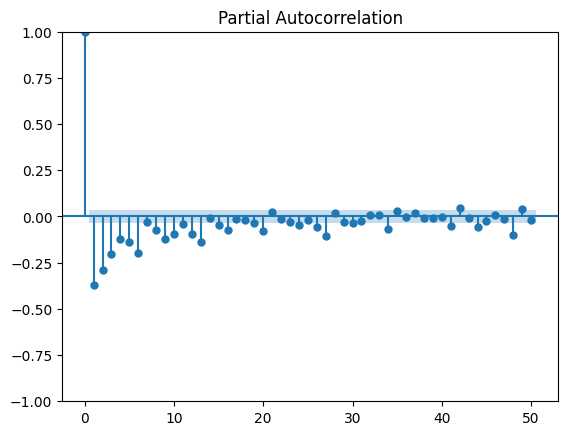

In [11]:
sm.graphics.tsa.plot_pacf(daily_analysis_arr.diff().dropna(), lags=50, method="ywm")
plt.show()

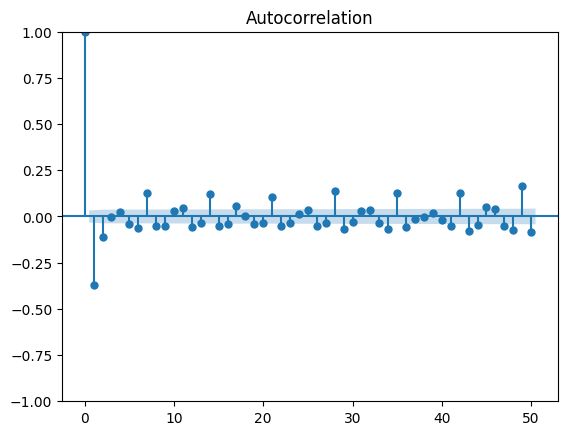

In [12]:
sm.graphics.tsa.plot_acf(daily_analysis_arr.diff().dropna(), lags=50)
plt.show()

### Prediction

In [13]:
daily_analysis_arr = daily_analysis_arr.asfreq('D').interpolate(method='linear')

In [14]:
daily_analysis_arr

FL_DATE
2009-01-01     0.896552
2009-01-02    43.400000
2009-01-03    -5.655172
2009-01-04    -5.333333
2009-01-05    16.371429
                ...    
2018-12-27    15.585366
2018-12-28    10.243902
2018-12-29    -1.970588
2018-12-30     0.243902
2018-12-31    -3.666667
Freq: D, Name: AVG_ARR_DELAY, Length: 3652, dtype: float64

In [32]:
# Numero di osservazioni nel dataset
nobs = len(daily_analysis_arr)

# Calcolo dell'indice di separazione per il training set (80% dei dati)
n_init_training = int(nobs * 0.8)

# Separazione dei dati in training e test set
training_data = daily_analysis_arr[:n_init_training]
test_data = daily_analysis_arr[n_init_training-1:]

In [ ]:
# Serie temporale: dati
model = auto_arima(training_data, seasonal=False, trace=True)

# Fit del modello
model_fit.fit(training_data)

# Previsioni
forecast = model_fit.fittedvalues

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23858.197, Time=4.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24991.660, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24589.625, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24050.210, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24989.661, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23856.630, Time=1.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23857.415, Time=2.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24328.297, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24225.377, Time=2.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.48 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=23855.415, Time=1.64 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23855.987, Time=0.82 sec
 ARIMA(2,1,0)(0,0,0)[0]             :

In [35]:
# Creazione del modello ARIMA (senza componente stagionale)
model = ARIMA(training_data, order=(2, 1, 1))

# Allenamento del modello ARIMA
model_fit = model.fit()

forecast = model_fit.fittedvalues

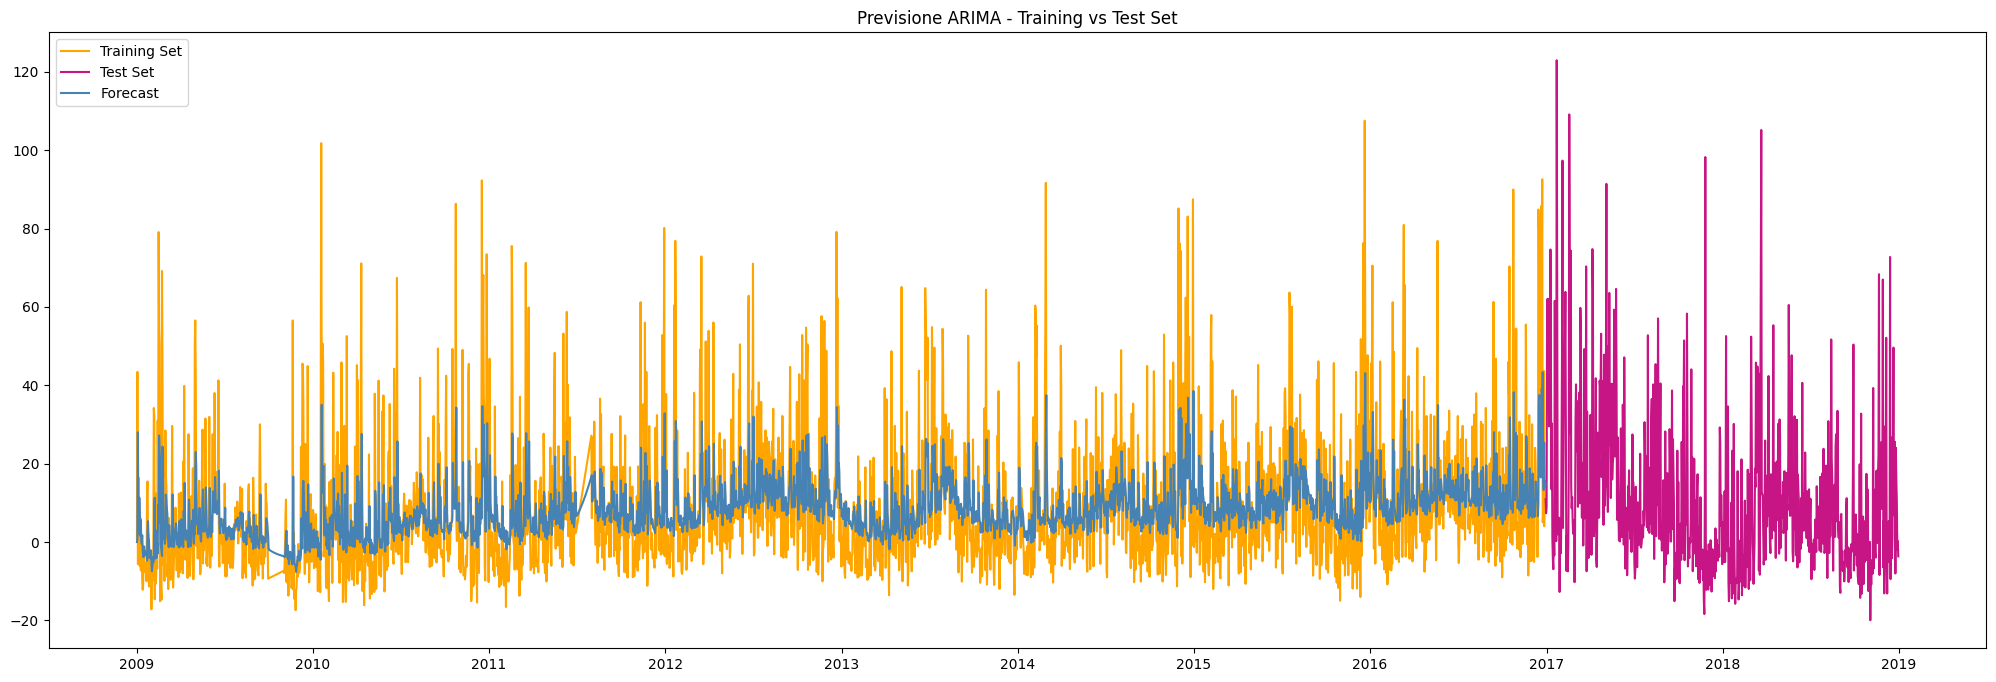

                               SARIMAX Results                                
Dep. Variable:          AVG_ARR_DELAY   No. Observations:                 2921
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -12090.992
Date:                Sat, 23 Nov 2024   AIC                          24189.984
Time:                        16:20:33   BIC                          24213.902
Sample:                    01-01-2009   HQIC                         24198.599
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3153      0.014     21.936      0.000       0.287       0.343
ar.L2          0.0399      0.015      2.717      0.007       0.011       0.069
ma.L1         -0.9860      0.003   -289.390      0.0

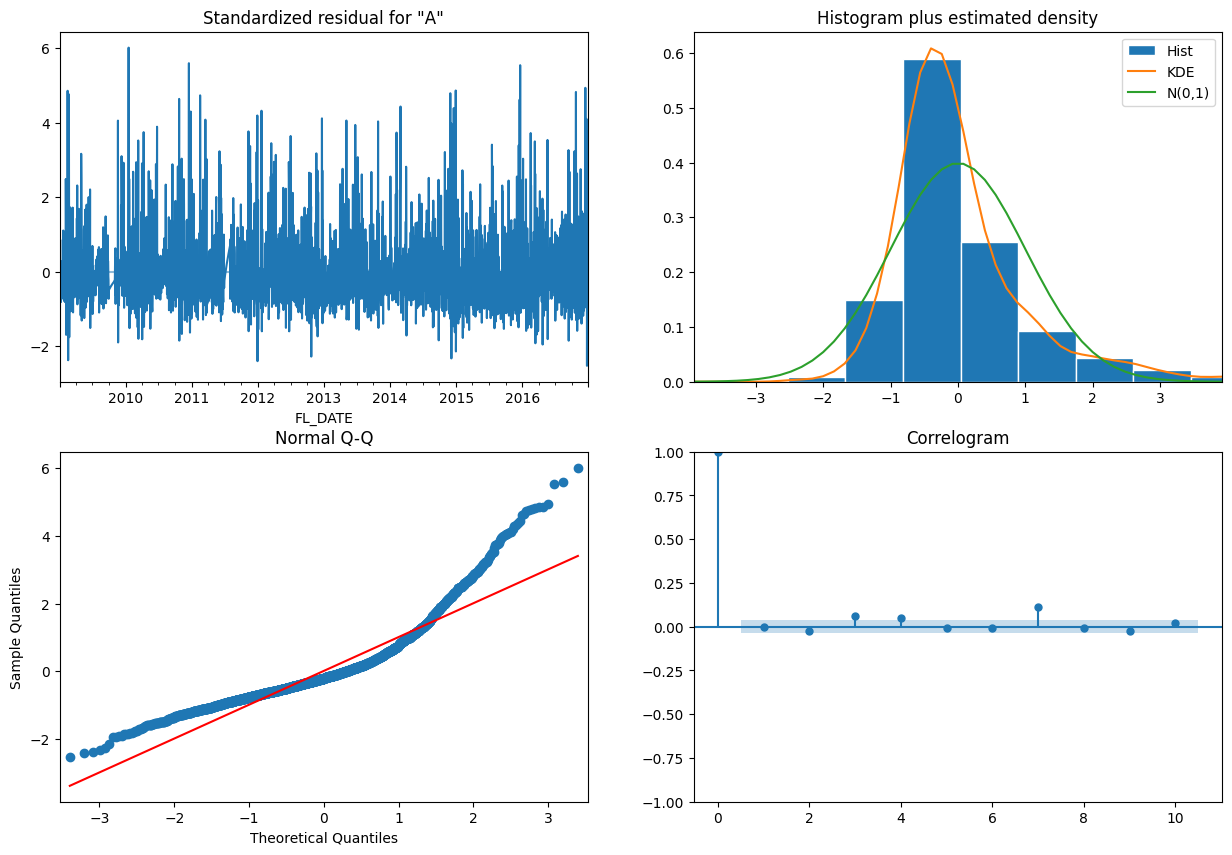

In [17]:
# Visualizzazione dei risultati
fig, ax = plt.subplots(figsize=(25, 8))

# Grafico dei dati
ax.plot(training_data, color='orange', label='Training Set')  
ax.plot(test_data, color='mediumvioletred', label='Test Set')  
ax.plot(forecast, color='steelblue', label='Forecast')  

# Aggiunta della legenda e del titolo
ax.legend(loc='upper left')
ax.set_title('Previsione ARIMA - Training vs Test Set')

# Mostra il grafico
plt.show()

# Stampa del sommario dei risultati del modello
print(model_fit.summary())

# Dettagli aggiuntivi sul periodo considerato
print(f"Numero di elementi nel periodo: {nobs}")
print(f"Indice dell'ultimo elemento del training set: {n_init_training}")

# Diagnostica dei residui
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()


### Predizione

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['freq']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


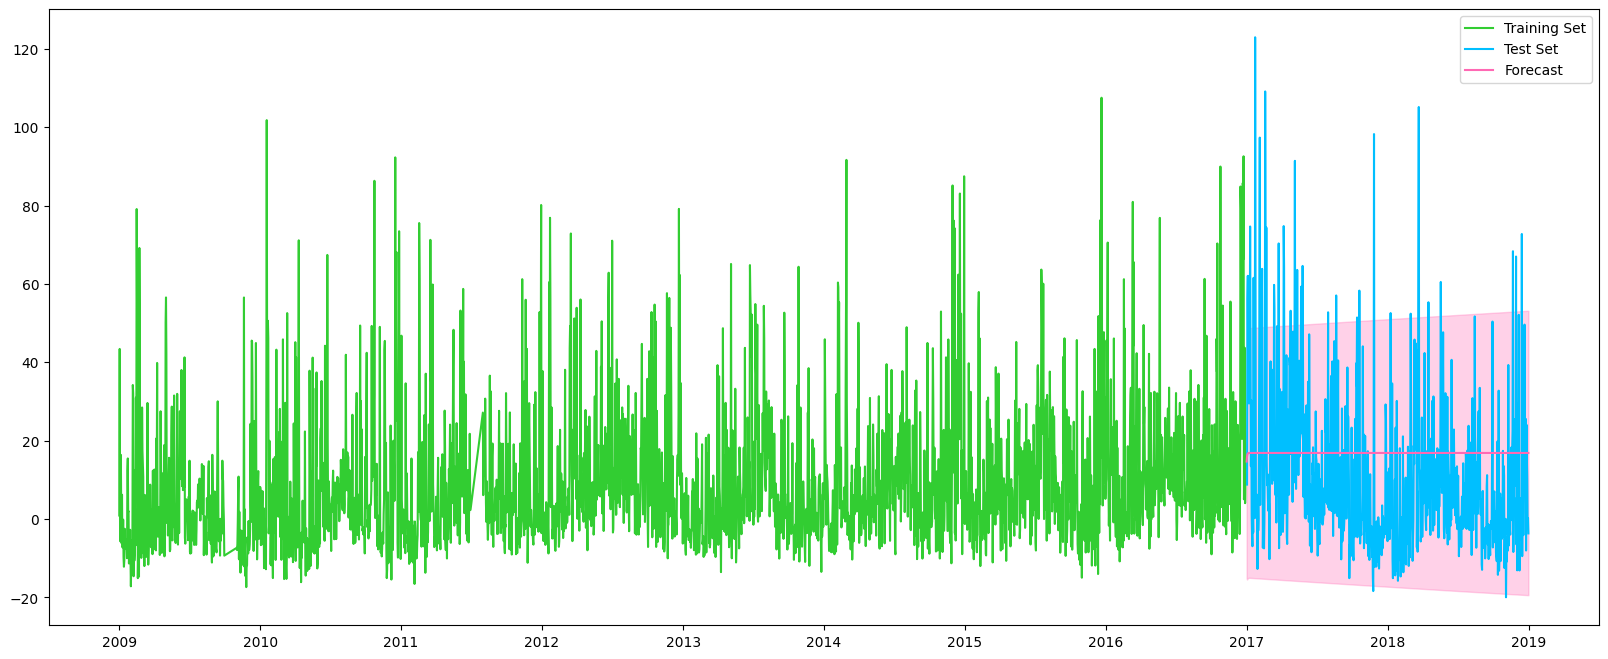

In [58]:
fig = plt.figure(figsize=(20,8))
x2 = model_fit.get_prediction(start=training_data.index[-1] + pd.Timedelta(days=1), end=test_data.index[-1], freq='D').summary_frame()

plt.plot(training_data, color='limegreen')
plt.plot(daily_analysis_arr[n_init_training+1:],color='deepskyblue')
plt.plot(x2['mean'], color='hotpink')
plt.legend([ 'Training Set','Test Set', 'Forecast'])
plt.fill_between(x2.index, x2['mean_ci_lower'], x2['mean_ci_upper'], color='hotpink', alpha=0.3)

In [46]:
print(test_data.index[0])

2016-12-30 00:00:00


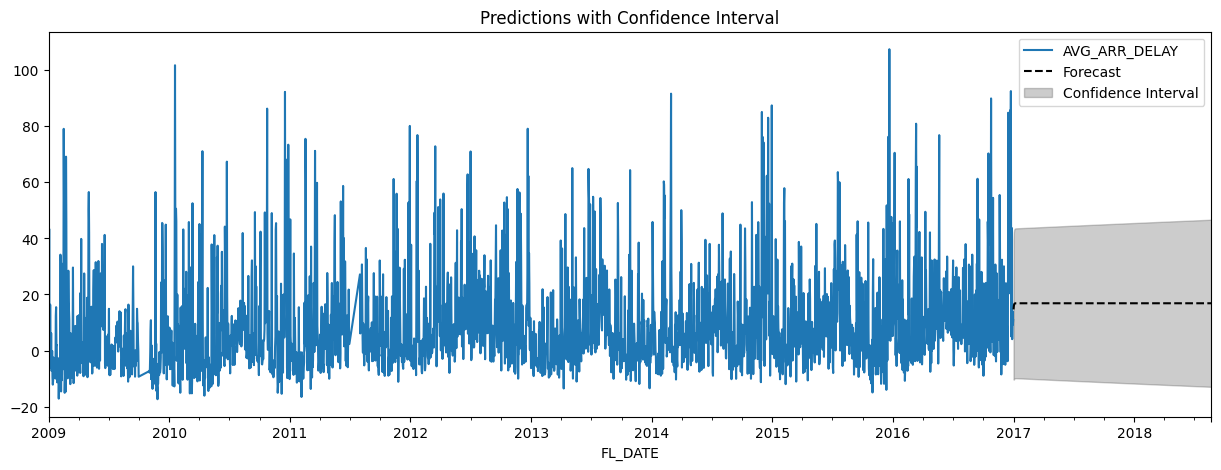

AVG_ARR_DELAY       mean    mean_se  mean_ci_lower  mean_ci_upper
2016-12-31     14.672816  15.200397     -10.329612      39.675244
2017-01-01     15.933108  16.003266     -10.389923      42.256139
2017-01-02     16.481550  16.181763     -10.135081      43.098181
2017-01-03     16.704721  16.223857      -9.981149      43.390591
2017-01-04     16.796953  16.237954      -9.912104      43.506010
...                  ...        ...            ...            ...
2018-08-18     16.861553  18.114425     -12.934025      46.657130
2018-08-19     16.861553  18.117427     -12.938962      46.662068
2018-08-20     16.861553  18.120428     -12.943899      46.667004
2018-08-21     16.861553  18.123429     -12.948835      46.671940
2018-08-22     16.861553  18.126429     -12.953770      46.676875

[600 rows x 4 columns]


In [61]:
forecast = model_fit.get_forecast(steps=600)
fcast = forecast.summary_frame(alpha=0.10)
forecast_idx = pd.date_range(start=training_data.index[-1] + pd.Timedelta(days=1), periods=600, freq='D')
fcast.index = forecast_idx

# Grafico
fig, ax = plt.subplots(figsize=(15, 5))
training_data[0:].plot(ax=ax)
fcast['mean'].plot(ax=ax, style='k--', label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Predictions with Confidence Interval")
plt.show()
print(fcast)


### altro

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


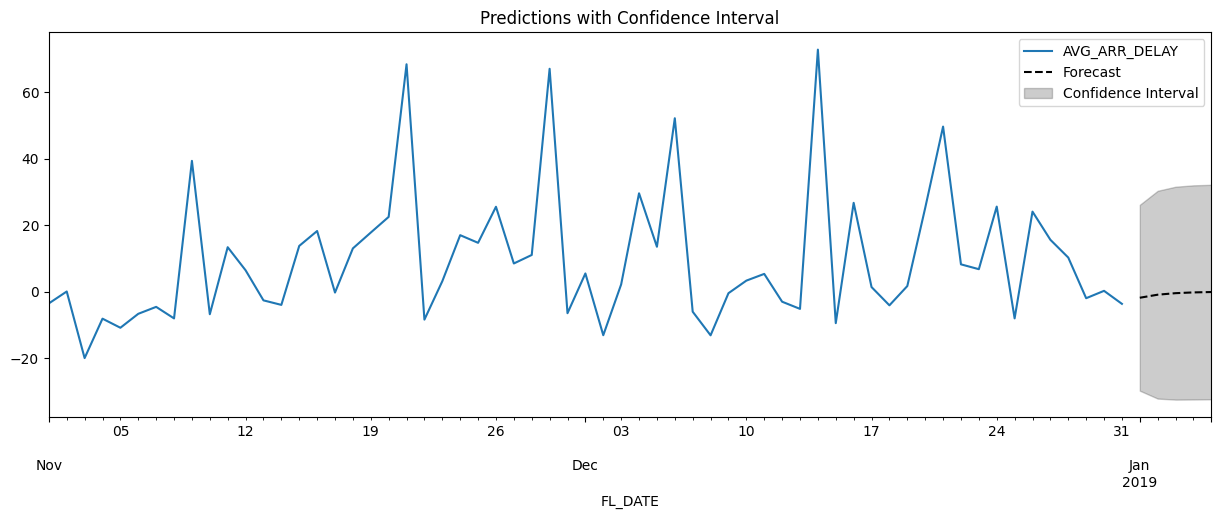

In [ ]:
forecast = results.get_forecast(steps=5)
fcast = forecast.summary_frame(alpha=0.10)
forecast_idx = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
fcast.index = forecast_idx

# Grafico
fig, ax = plt.subplots(figsize=(15, 5))
y.loc['2018-11-01':].plot(ax=ax) # Data per rendere visibile la predizione
fcast['mean'].plot(ax=ax, style='k--', label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Predictions with Confidence Interval")
plt.show()


In [18]:
nforecasts = 5
forecasts = {}

# Settiamo il numero di elementi del training set considerando di prendere l'80% dei dati a disposizione
d_len = len(y)
train = int(0.8 * len(y))  # 80% training

# Creiamo il modello per il training
init_training_y = y.iloc[:train]
mod = sm.tsa.SARIMAX(init_training_y, order=(2, 0, 0), trend='c')
res = mod.fit()

# Salviamo il forecast iniziale
forecasts[init_training_y.index[-2]] = res.forecast(steps=nforecasts)

# Andiamo avanti per i vari componenti del campione
for t in range(train, d_len):
    # aggiorniamo il risultato con l'append della nuova osservazione
    updated_y = y.iloc[t:t+1]
    res = res.append(updated_y, refit=False)
    # Salviasmo il nuovo insieme di forecasts
    forecasts[updated_y.index[0]] = res.forecast(steps=nforecasts)

# Mettiamo insieme tutti i forecasts in un dataframe
forecasts = pd.concat(forecasts, axis=1)

forecasts.iloc[:5, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
2016-12-31,9.506428,NaN,NaN,NaN,NaN
2017-01-01,9.143844,8.420121,NaN,NaN,NaN
2017-01-02,8.939971,8.568217,8.691346,NaN,NaN
2017-01-03,8.849999,8.682193,8.745441,24.640609,NaN
2017-01-04,8.807667,8.729222,8.757771,16.922612,29.448045


In [17]:
# Calcoliamo l'errore del forecast
forecast_errors = forecasts.apply(lambda column: y - column).reindex(forecasts.index)
# Re-indicizziamo i forecasts 
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

flattened.iloc[:3, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
horizon,,,,,
1,-2.161601,0.367758,47.475321,37.410673,3.768171
2,-0.355965,47.598450,53.305841,16.293604,43.115423
3,47.226696,53.369089,24.458445,49.549338,16.104567


In [19]:
# Calcoliamo lo squarto quadratico medio
rmse = (flattened**2).mean(axis=1)**0.5

rmse

horizon
1    18.615898
2    19.527456
3    19.829986
4    19.880525
5    19.888082
dtype: float64

## Departure delay

In [25]:
y = daily_analysis['AVG_DEP_DELAY']

# Costruzione del modello AR(1)
model = sm.tsa.SARIMAX(y, order=(1, 0, 0), trend='n')  # AR(1), no trend
results = model.fit()
y = y.asfreq('D')
# Stima dei parametri
results.summary()

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          AVG_DEP_DELAY   No. Observations:                 3590
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -14872.257
Date:                Sat, 23 Nov 2024   AIC                          29748.514
Time:                        10:21:05   BIC                          29760.885
Sample:                             0   HQIC                         29752.923
                               - 3590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5875      0.010     58.040      0.000       0.568       0.607
sigma2       232.1879      3.053     76.044      0.000     226.203     238.172
===================================================================================
Ljung-Box (L1) (Q):                 233.51   Jarque-Bera (JB):              3823.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             1.33
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


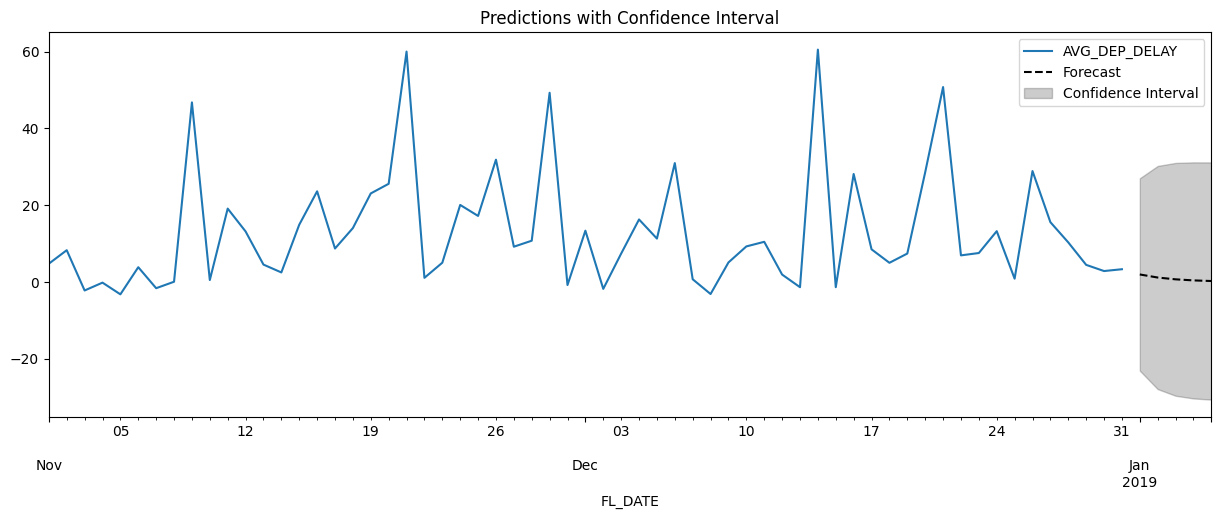

In [26]:
# Imposta una frequenza per i dati storici
y = y.asfreq('D')

# Previsioni
forecast = results.get_forecast(steps=5)
fcast = forecast.summary_frame(alpha=0.10)
forecast_idx = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
fcast.index = forecast_idx

# Grafico
fig, ax = plt.subplots(figsize=(15, 5))
y.loc['2018-11-01':].plot(ax=ax) # Data per rendere visibile la predizione
fcast['mean'].plot(ax=ax, style='k--', label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Predictions with Confidence Interval")
plt.show()


In [27]:
nforecasts = 5
forecasts = {}

# Settiamo il numero di elementi del training set considerando di prendere l'80% dei dati a disposizione
d_len = len(y)
train = int(0.8 * len(y))  # 80% training

# Creiamo il modello per il training
init_training_y = y.iloc[:train]
mod = sm.tsa.SARIMAX(init_training_y, order=(2, 0, 0), trend='c')
res = mod.fit()

# Salviamo il forecast iniziale
forecasts[init_training_y.index[-2]] = res.forecast(steps=nforecasts)

# Andiamo avanti per i vari componenti del campione
for t in range(train, d_len):
    # aggiorniamo il risultato con l'append della nuova osservazione
    updated_y = y.iloc[t:t+1]
    res = res.append(updated_y, refit=False)
    # Salviasmo il nuovo insieme di forecasts
    forecasts[updated_y.index[0]] = res.forecast(steps=nforecasts)

# Mettiamo insieme tutti i forecasts in un dataframe
forecasts = pd.concat(forecasts, axis=1)

forecasts.iloc[:5, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
2016-12-31,10.999647,NaN,NaN,NaN,NaN
2017-01-01,11.420173,9.458592,NaN,NaN,NaN
2017-01-02,11.601842,10.624396,9.667500,NaN,NaN
2017-01-03,11.682599,11.265698,10.788881,23.560678,NaN
2017-01-04,11.718190,11.532141,11.328768,17.692892,28.879903


In [28]:
# Calcoliamo l'errore del forecast
forecast_errors = forecasts.apply(lambda column: y - column).reindex(forecasts.index)
# Re-indicizziamo i forecasts 
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

flattened.iloc[:3, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
horizon,,,,,
1,-6.344475,-3.094956,41.308691,36.182912,3.336313
2,-5.056537,40.351794,48.954709,14.523325,38.386720
3,39.374348,48.477892,20.887448,43.961152,9.009478


In [29]:
# Calcoliamo lo squarto quadratico medio
rmse = (flattened**2).mean(axis=1)**0.5

rmse

horizon
1    15.000620
2    15.614679
3    15.790582
4    15.756868
5    15.697590
dtype: float64

## Flight time

In [30]:
y = daily_analysis['AVG_AIR_TIME']

# Costruzione del modello AR(1)
model = sm.tsa.SARIMAX(y, order=(1, 0, 0), trend='n')  # AR(1), no trend
results = model.fit()
y = y.asfreq('D')
# Stima dei parametri
results.summary()

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AVG_AIR_TIME   No. Observations:                 3590
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -9018.830
Date:                Sat, 23 Nov 2024   AIC                          18041.659
Time:                        10:21:55   BIC                          18054.031
Sample:                             0   HQIC                         18046.069
                               - 3590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.001   1045.548      0.000       0.997       1.000
sigma2         8.8899      0.100     88.880      0.000       8.694       9.086
===================================================================================
Ljung-Box (L1) (Q):                 369.03   Jarque-Bera (JB):              7414.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.28
Prob(H) (two-sided):                  0.80   Kurtosis:                        10.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


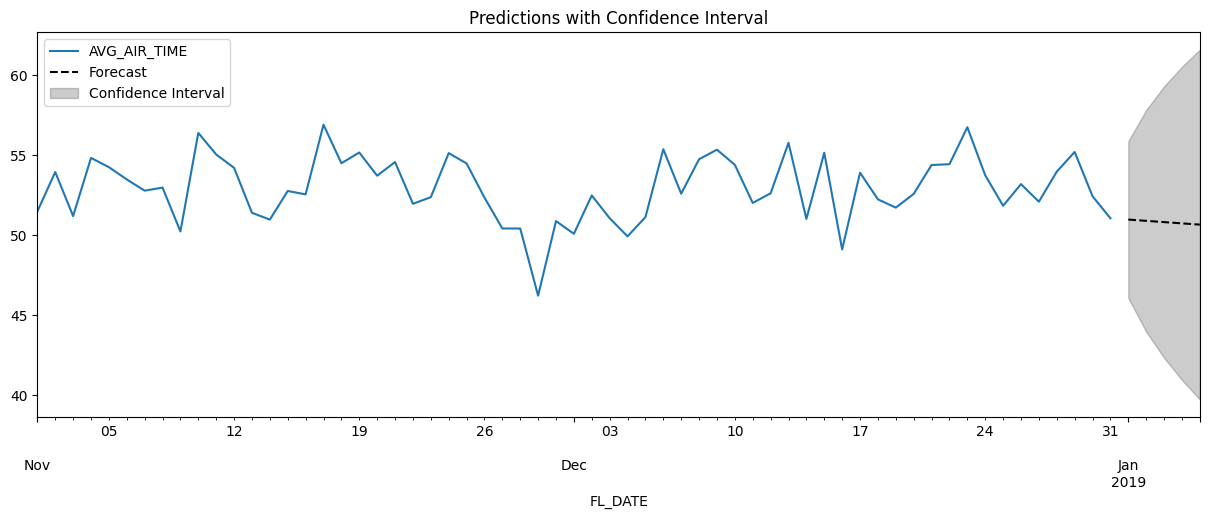

In [31]:
# Imposta una frequenza per i dati storici
y = y.asfreq('D')

# Previsioni
forecast = results.get_forecast(steps=5)
fcast = forecast.summary_frame(alpha=0.10)
forecast_idx = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
fcast.index = forecast_idx

# Grafico
fig, ax = plt.subplots(figsize=(15, 5))
y.loc['2018-11-01':].plot(ax=ax) # Data per rendere visibile la predizione
fcast['mean'].plot(ax=ax, style='k--', label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Predictions with Confidence Interval")
plt.show()


In [32]:
nforecasts = 5
forecasts = {}

# Settiamo il numero di elementi del training set considerando di prendere l'80% dei dati a disposizione
d_len = len(y)
train = int(0.8 * len(y))  # 80% training

# Creiamo il modello per il training
init_training_y = y.iloc[:train]
mod = sm.tsa.SARIMAX(init_training_y, order=(2, 0, 0), trend='c')
res = mod.fit()

# Salviamo il forecast iniziale
forecasts[init_training_y.index[-2]] = res.forecast(steps=nforecasts)

# Andiamo avanti per i vari componenti del campione
for t in range(train, d_len):
    # aggiorniamo il risultato con l'append della nuova osservazione
    updated_y = y.iloc[t:t+1]
    res = res.append(updated_y, refit=False)
    # Salviasmo il nuovo insieme di forecasts
    forecasts[updated_y.index[0]] = res.forecast(steps=nforecasts)

# Mettiamo insieme tutti i forecasts in un dataframe
forecasts = pd.concat(forecasts, axis=1)

forecasts.iloc[:5, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
2016-12-31,55.450832,NaN,NaN,NaN,NaN
2017-01-01,54.639815,56.175242,NaN,NaN,NaN
2017-01-02,54.187567,55.053429,53.602102,NaN,NaN
2017-01-03,53.946726,54.406827,53.588391,52.493915,NaN
2017-01-04,53.817288,54.064676,53.629776,53.012576,48.263746


In [33]:
# Calcoliamo l'errore del forecast
forecast_errors = forecasts.apply(lambda column: y - column).reindex(forecasts.index)
# Re-indicizziamo i forecasts 
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

flattened.iloc[:3, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
horizon,,,,,
1,3.583651,-3.387363,-2.554483,-11.083658,2.601119
2,-1.851936,-4.005810,-12.178135,-2.147711,-1.456561
3,-3.139948,-12.996571,-2.764911,-4.134534,0.258781


In [23]:
# Calcoliamo lo squarto quadratico medio
rmse = (flattened**2).mean(axis=1)**0.5

rmse

horizon
1    18.615898
2    19.527456
3    19.829986
4    19.880525
5    19.888082
dtype: float64